In [26]:
import math
import struct
from math import cos, log, pi, sin, sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

plt.rcParams.update({"font.size": 20})

In [69]:
# Utils
def BoxMuller(mean, var):
    # y = x*sigma + var
    # => y = sqrt(-2*ln(a)) * cos(2*pi*b) * sigma + mu
    a = np.random.uniform()
    b = np.random.uniform()
    sigma = sqrt(var)

    return sqrt(-2 * log(a)) * sin(2 * pi * b) * sigma + mean


def buildFeatureMat(mean, var, N):
    # [1 x y]
    generate_x = []
    generate_y = []
    init_x = BoxMuller(mean, var)
    init_y = BoxMuller(mean, var)
    generate_x.append(init_x)
    generate_y.append(init_y)
    feature = np.array([1, init_x, init_y])

    for _ in range(N - 1):
        new_x = BoxMuller(mean, var)
        new_y = BoxMuller(mean, var)
        generate_x.append(new_x)
        generate_y.append(new_y)
        newdata = np.array([1, new_x, new_y])
        feature = np.vstack((feature, newdata))
    return feature, generate_x, generate_y


def safe_ln(x):
    return np.log(np.where(x > 1e-14, x, 1e-14))

In [70]:
# Part 1: Logistic Regression
def sigmoid(x):
    # vectorized sigmoid
    return 1 / (1 + np.exp(-x))


def predict(feature, weight):
    return sigmoid(feature.dot(weight))


# instead of using LSE, we use Cross Entropy as loss function here
def logloss(feature, label, w):
    """
    N = 50+50 = 100
    Feature matrix: 100 x 3
    label(0 or 1): 100 x 1
    weights: 3 x 1
    h(prediction): 100 x 1
    """
    h = predict(feature, w)
    m = len(label)
    cost = np.asscalar(np.dot(-label.T, safe_ln(h)) - np.dot((1 - label).T, safe_ln(1 - h)))
    cost = cost / m
    return cost


def updateW(feature, label, w, learn_rate):
    """
    Feature: 100 x 3
    label: 100 x 1
    weights: 3 x 1
    learning rate: scalar
    """
    h = predict(feature, w)  # 100 x 1
    gradient = np.dot((h - label).T, feature)  # 1 x 100 x 100 x 3 => 1 x 3

    return w - learn_rate * gradient.T


def GD(feature, label, lr=1, iters=1000):
    # initialize weights:
    cost = 0
    w = np.zeros((3, 1))
    cost_log = []
    for i in range(iters):
        prev_cost = cost
        w = updateW(feature, label, w, lr)
        cost = logloss(feature, label, w)
        if i >= 100 and abs(cost - prev_cost) <= 1e-2:
            break
        cost_log.append(cost)
    return w, cost_log


def genMatD(d):
    D = np.eye(len(d))
    for i in range(len(d)):
        D[i, i] = d[i]
    return D


def Newton(feature, label, lr=1, iters=1000):
    """
    weight: 3 x 1
    Feature: 100 x 3
    label: 100 x 1
    Hessian: 3 x 3
    gradient: 3 x 1
    """
    w = np.zeros((3, 1))
    cost = 0
    cost_log = []

    for i in range(iters):
        prev_cost = cost
        h = predict(feature, w)

        # Calculate Gradient
        gradient = np.dot(feature.T, (h - label))

        # Calculate Hessian
        D = genMatD(np.dot(genMatD(h), 1 - h))
        Hessian = np.dot(feature.T.dot(D), feature)

        # Update weight
        try:
            delta = np.linalg.inv(Hessian).dot(gradient)
        except:
            delta = gradient
        w = w - delta * lr

        cost = logloss(feature, label, w)
        cost_log.append(cost)
        if i >= 100 and abs(cost - prev_cost) <= 1e-2:
            break

    return w, cost_log

In [71]:
def LogisticReg(m1, v1, m2, v2, N, a=1):
    # Generate data
    D1_feature, D1_x, D1_y = buildFeatureMat(m1, v1, N)
    D2_feature, D2_x, D2_y = buildFeatureMat(m2, v2, N)
    Data_x = D1_x + D2_x
    Data_y = D1_y + D2_y
    Data_feature = np.vstack((D1_feature, D2_feature))
    D1_label = np.zeros((N, 1))
    D2_label = np.ones((N, 1))
    Data_label = np.vstack((D1_label, D2_label))

    # Visualize and output result
    # Ground Truth
    ground_truth = Data_label.flatten()
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    for x, y in zip(D1_x, D1_y):
        plt.scatter(x, y, c="red")
    for x, y in zip(D2_x, D2_y):
        plt.scatter(x, y, c="blue")

    # GD:
    print("Gradient descent:\n")
    weight, cost_log = GD(Data_feature, Data_label, lr=a)

    print("w:")
    for w in weight:
        print(" %10f" % w)

    # Classify predict result
    pred_label = Data_feature.dot(weight)
    pred_label = sigmoid(pred_label.flatten())
    pred_label[pred_label >= 0.5] = 1
    pred_label[pred_label < 0.5] = 0

    # Print cm and specificity, sensitivity
    print("\nConfusion Matrix:")
    cm = confusion_matrix(ground_truth, pred_label)
    print(cm)
    print("\nSensitivity (Successfully predict cluster 1):", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
    print("Specificity (Successfully predict cluster 2):", cm[1, 1] / (cm[1, 0] + cm[1, 1]))

    # plot predict result
    plt.subplot(1, 3, 2)
    plt.title("Gradient Descent")

    for i in range(len(Data_x)):
        if pred_label[i] == 0:
            plt.scatter(Data_x[i], Data_y[i], c="red", label="cluster 1")
        else:
            plt.scatter(Data_x[i], Data_y[i], c="blue", label="cluster 2")

    print("-------------------------------------")

    # Newton's
    print("Newton's method:")
    newton_weight, new_cost_log = Newton(Data_feature, Data_label, lr=a)

    print("\nw:")
    for w in newton_weight:
        print(" %10f" % w)

    # Classify predict result
    new_pred_label = Data_feature.dot(newton_weight)
    new_pred_label = sigmoid(new_pred_label.flatten())
    new_pred_label[new_pred_label >= 0.5] = 1
    new_pred_label[new_pred_label < 0.5] = 0

    # Print cm and specificity, sensitivity
    print("\nConfusion Matrix:")
    cm = confusion_matrix(ground_truth, new_pred_label)
    print(cm)
    print("\nSensitivity (Successfully predict cluster 1):", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
    print("Specificity (Successfully predict cluster 2):", cm[1, 1] / (cm[1, 0] + cm[1, 1]))

    # Plot predict result
    plt.subplot(1, 3, 3)
    plt.title("Newton's method")
    for i in range(len(Data_x)):
        if new_pred_label[i] == 0:
            plt.scatter(Data_x[i], Data_y[i], c="red", label="cluster 1")
        else:
            plt.scatter(Data_x[i], Data_y[i], c="blue", label="cluster 2")

Gradient descent:

w:
 -149.352017
   2.004221
  34.909328

Confusion Matrix:
[[50  0]
 [ 0 50]]

Sensitivity (Successfully predict cluster 1): 1.0
Specificity (Successfully predict cluster 2): 1.0
-------------------------------------
Newton's method:

w:
 -154.196083
  10.490483
  13.792424

Confusion Matrix:
[[50  0]
 [ 0 50]]

Sensitivity (Successfully predict cluster 1): 1.0
Specificity (Successfully predict cluster 2): 1.0


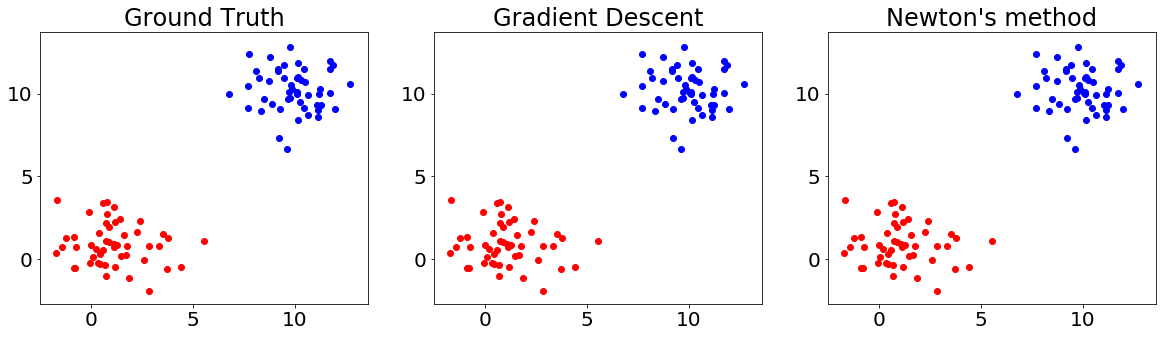

In [72]:
# Case 1: N=50, mx1=my1=1, mx2=my2=10, vx1=vy1=vx2=vy2=2
LogisticReg(1, 2, 10, 2, 50)

Gradient descent:

w:
 -186.548591
  17.778222
  47.470753

Confusion Matrix:
[[49  1]
 [19 31]]

Sensitivity (Successfully predict cluster 1): 0.98
Specificity (Successfully predict cluster 2): 0.62
-------------------------------------
Newton's method:

w:
  -3.258926
   0.532089
   1.068298

Confusion Matrix:
[[41  9]
 [ 9 41]]

Sensitivity (Successfully predict cluster 1): 0.82
Specificity (Successfully predict cluster 2): 0.82


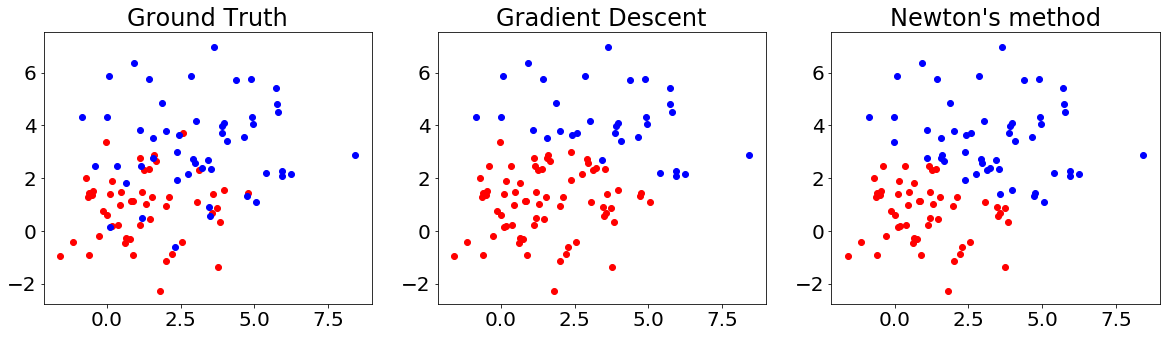

In [75]:
# Case 2: N=50, mx1=my1=1, mx2=my2=3, vx1=vy1=2, vx2=vy2=4
LogisticReg(1, 2, 3, 4, 50)

In [93]:
# Part 2: EM Algorithm
def read_idx(filename):
    with open(filename, "rb") as f:
        zero, data_type, dims = struct.unpack(">HBB", f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


train_data = read_idx("./mnist/train-images.idx3-ubyte")
train_label = read_idx("./mnist/train-labels.idx1-ubyte")
test_data = read_idx("./mnist/t10k-images.idx3-ubyte")
test_label = read_idx("./mnist/t10k-labels.idx1-ubyte")

In [94]:
# Binning grayscale to binary
train = np.copy(train_data)
train = np.where(train > 127, 1, 0)
flatten_train = []
for data in train:
    flatten_train.append(data.flatten())
train = np.array(flatten_train)

In [95]:
# initial parameter
k = np.ones(10) / 10
p = np.random.rand(10, 784)  # 784 pixels
iters = 100
i = 0
for i in range(iters):
    # E step
    # first calculate log probability
    w = train.dot(safe_ln(p.T)) + (1 - train).dot(safe_ln(1 - p.T)) + safe_ln(k)
    N = w.shape[0]
    w = (w.T - np.max(w, axis=1)).T  # normalize(in log scale)
    # return to original probability(in exp scale)
    w = np.exp(w)
    w = (w.T / np.sum(w, axis=1)).T

    # M step
    k_new = np.sum(w, axis=0) / N
    p_new = (train.T.dot(w) / np.sum(w, axis=0)).T

    # Check if converges
    if np.all(k - k_new < 1e-4) and np.all(p - p_new < 1e-4) and i > 10:
        break

    k = k_new
    p = p_new

print("Total iters:", i + 1)

Total iters: 100


In [96]:
# label groups
pred = []
for i in range(len(w)):
    pred.append(np.argmax(w[i]))
cm = confusion_matrix(train_label, pred)

In [97]:
cm

array([[  88,  890,    5,  197,   27,    3,    2, 4384,  327,    0],
       [  27,  335,   26,   11,   15,   46,    6,    0,   39, 6237],
       [ 240,  379, 4430,  335,  194,   17,   10,   46,  187,  120],
       [  46,  402,  247, 3703,  102,  172,   23,   21, 1209,  206],
       [  81,  449,   21,    0, 2261, 1520, 1445,   10,   17,   38],
       [  80, 1777,   10, 1564,  189,  120,  115,   59, 1465,   42],
       [4478, 1023,   41,   36,   76,    0,    1,   57,   76,  130],
       [   5,   65,   41,   13,  807, 2286, 2846,   13,   25,  164],
       [  27,  722,   38, 1010,  148,  107,  107,   33, 3385,  274],
       [   1,   55,    5,   72, 1523, 2457, 1651,   20,   89,   76]],
      dtype=int64)

In [89]:
def printCM(num, TP, FP, FN):
    print("Confusion Matrx %d:" % num)
    ws = ""
    first_row_0 = "Predict number %d" % num
    first_row_1 = "Predict number not %d" % num
    print(f"{ws:<17}{first_row_0:<22}{first_row_1:<22}")
    sec_row_0 = "Is number %d" % num
    sec_row_1 = TP
    sec_row_2 = FP
    print(f"{sec_row_0:<22}{sec_row_1:<22}{sec_row_2:<22}")
    thi_row_0 = "Isn't num %d" % num
    thi_row_1 = FN
    TN = 60000 - TP - FP - FN
    thi_row_2 = TN
    print(f"{thi_row_0:<22}{thi_row_1:<22}{thi_row_2:<22}")
    print("\nSensitivity (Successfully predict number %d): %f" % (num, TP / (TP + FN)))
    print("Specificity (Successfully predict not number %d): %f" % (num, TN / (TN + FP)))
    print("--------------------------------------------------------")

In [108]:
label = cm.argmax(axis=0)
pred = cm.argmax(axis=1)
print("Ground Truth:", label)
print("Cluster:     ", pred)

Ground Truth: [6 5 2 3 4 9 7 0 8 1]
Cluster:      [7 9 2 3 4 1 0 6 8 5]


In [111]:
dict_cluster = dict(zip(pred, label))
print(dict_cluster)
for i in range(10):
    for k, v in dict_cluster.items():
        if v == i:
            cm_idx = k
    printCM(cm_idx, cm.argmax(axis=1)[cm_idx], )

{7: 6, 9: 5, 2: 2, 3: 3, 4: 4, 1: 9, 0: 7, 6: 0, 8: 8, 5: 1}


'\nfor i in range(10):\n    for truth in dict_cluster.items():\n        if truth == :\n            print(cluster)\n'

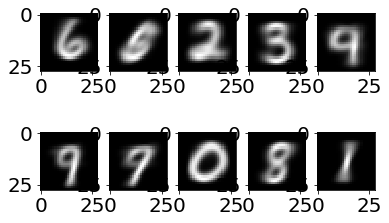

In [99]:
plt.figure()
for i in range(10):
    img = p[i].reshape((28, 28))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap="gray")